## Import Dataset

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d parulpandey/emotion-dataset

  0% 0.00/715k [00:00<?, ?B/s]
100% 715k/715k [00:00<00:00, 46.0MB/s]


In [ ]:
! unzip /content/emotion-dataset.zip

Archive:  /content/emotion-dataset.zip
  inflating: test.csv                
  inflating: training.csv            
  inflating: validation.csv          


## Import necessary libraries

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train = pd.read_csv('/content/training.csv')
test = pd.read_csv('/content/test.csv')
validation = pd.read_csv('/content/validation.csv')

In [ ]:
# as per the dataset description, key-value is mapped with the corresponding emotion

labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['description'] = train['label'].map(labels_dict )
train.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Preprocessing the text

In [ ]:
train_txt = train.text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_txt)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def text_encoding(txt):
    encoded_docs = tokenizer.texts_to_sequences(txt)
    padded_sequence = pad_sequences(encoded_docs, maxlen=128)    
       
    return padded_sequence

In [ ]:
train_txt = text_encoding(train_txt)
test_txt = text_encoding(test['text'])
val_txt = text_encoding(validation['text'])

## Label encoding

In [ ]:
def label_encoding(label):
    y = tf.keras.utils.to_categorical(label)    
    return y

In [ ]:
y_train = label_encoding(train['label'])
y_test = label_encoding(test['label'])
y_val = label_encoding(validation['label'])

## Building the model

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 128))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1947264   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

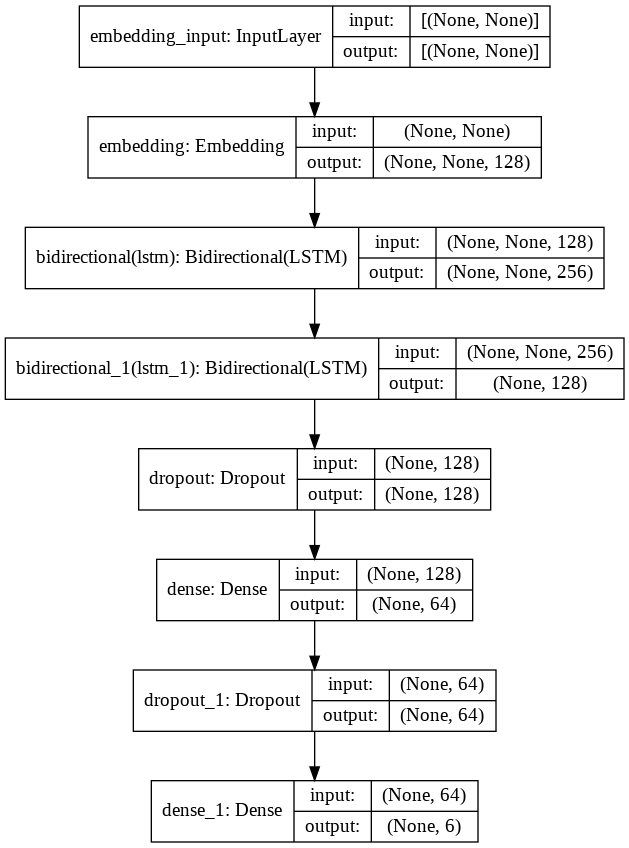

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Model training

In [ ]:
history = model.fit(x=train_txt, y=y_train,epochs=5, batch_size=32, validation_data=(test_txt, y_test))

Epoch 1/5
500/500 [==============================] - 86s 153ms/step - loss: 1.0692 - accuracy: 0.5719 - val_loss: 0.5342 - val_accuracy: 0.7965
Epoch 2/5
500/500 [==============================] - 75s 150ms/step - loss: 0.3831 - accuracy: 0.8683 - val_loss: 0.2726 - val_accuracy: 0.9030
Epoch 3/5
500/500 [==============================] - 75s 149ms/step - loss: 0.2002 - accuracy: 0.9279 - val_loss: 0.2060 - val_accuracy: 0.9165
Epoch 4/5
500/500 [==============================] - 75s 150ms/step - loss: 0.1292 - accuracy: 0.9522 - val_loss: 0.2256 - val_accuracy: 0.9140
Epoch 5/5
500/500 [==============================] - 75s 150ms/step - loss: 0.0990 - accuracy: 0.9622 - val_loss: 0.2299 - val_accuracy: 0.9150


In [ ]:
test_loss, test_acc = model.evaluate(test_txt, y_test)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

63/63 [==============================] - 3s 51ms/step - loss: 0.2299 - accuracy: 0.9150
Test Loss: 0.22988361120224
Test Accuracy: 0.9150000214576721


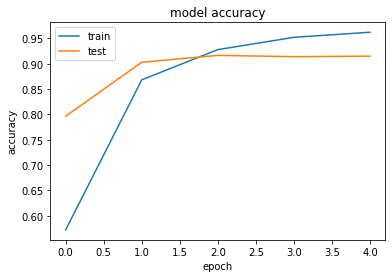

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

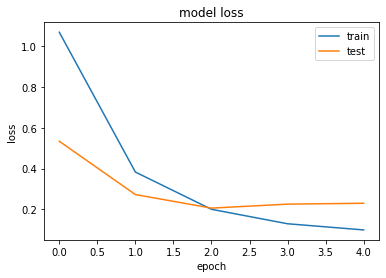

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Predictions

In [ ]:
predict_test = np.argmax(model.predict(test_txt),axis=-1)

In [ ]:
# as per the dataset description, index value is mapped with the corresponding emotion in the list

emotions = ['sadness','joy','love','anger','fear','surprise'] 

In [ ]:
def predict(n):    
    print(test['text'][n])
    print("Actual label: ",emotions[test['label'][n]])
    print("Predict label: ",emotions[predict_test[n]]) 
    

In [ ]:
n = 15
p = list(np.random.randint(low = 0, high = 2000, size = n))
for i in p:
    predict(i)
    print("-------------------------------------------------------------------------------------------")

i did a body scan and realized that everything was feeling amazing
Actual label:  surprise
Predict label:  surprise
-------------------------------------------------------------------------------------------
im in that last bit of sleep before i get up in the morning i feel like that emotional energy just waits for me
Actual label:  sadness
Predict label:  sadness
-------------------------------------------------------------------------------------------
i can t say for certain why but it actually makes me feel amused and you can be sure it s not just me because other people from our offices told me they have the same a href http news
Actual label:  joy
Predict label:  joy
-------------------------------------------------------------------------------------------
i feel as uncomfortable now as if i were carrying a volvo but my belly is nice and tidy and looks not unsimilar to the beer gut my dad has nice and hard and round and i waddle just like he does
Actual label:  fear
Predict labe

In [ ]:
def predict_text(test):
    txt = tokenizer.texts_to_sequences([test])
    txt = pad_sequences(txt,maxlen=128)
    pred = np.argmax(model.predict(txt))
    
    return emotions[pred]

In [ ]:
txt = '''Everyone keeps telling me that time heals all wounds, but no one can tell me what I’m supposed to do right now. 
Right now I can’t sleep. It’s right now that I can’t eat. Right now I still hear his voice and sense his presence 
even though I know he’s not here. Right now all I seem to do is cry. I know all about time and wounds healing, 
but even if I had all the time in the world, I still don’t know what to do with all this hurt right now.'''

print("Predicted emotion: ", predict_text(txt))

Predicted emotion:  sadness


In [ ]:
txt = '''Giving away something that was of great benefit or of requirement to the receiver definitely 
brings in a feel of happiness and fulfillment. No matter whatever situation you may be in, when you pass 
out things that are of great help and happiness to others, you too feel the same.'''

print("Predicted emotion: ", predict_text(txt))

Predicted emotion:  joy


In [ ]:
txt = '''Dogs are friendly and they love human companionship. Whose ego would not be gratified at the sight of 
a happy dog who can't wait to greet you at the end of a hard day ? Your dog waits for you by the door, face smiling, 
mouth open and tail wagging, ready to dote on you, his best friend in the world.'''

print("Predicted emotion: ", predict_text(txt))

Predicted emotion:  love


In [ ]:
txt = '''He well remembered the last interview he had had with the old prince at the time of the enrollment, 
when in reply to an invitation to dinner he had had to listen to an angry 
reprimand for not having provided his full quota of men.'''

print("Predicted emotion: ", predict_text(txt))

Predicted emotion:  anger


In [ ]:
txt = '''My childhood fear at the time unfortunately was scary movies, heights, and being afraid of the dark. 
As a young child, mainly around the age of 4 to 7 years old, 
screams and loud stressful noises wasn’t generally my favorite amusement. '''

print("Predicted emotion: ", predict_text(txt))

Predicted emotion:  fear


In [ ]:
txt = '''In my birthday my father gave me a pleasant surprise that is cycle. 
The sudden surpise of my father is shocking to me. I was very happy about what my father had gave me a nice gift on my birthday and 
my friends also wished me.'''

print("Predicted emotion: ", predict_text(txt))

Predicted emotion:  joy
